# Transfer Learning

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


### Get at the layers of the model

In [16]:
mobilenet_model=MobileNet(weights='imagenet',include_top=False,)

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in mobilenet_model.layers])
for layer in lgitayer_dict.keys():
    print(layer, layer_dict[layer])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['conv_dw_12'].output
print(x)

input_4 <keras.engine.input_layer.InputLayer object at 0x00000204075D6688>
conv1_pad <keras.layers.convolutional.ZeroPadding2D object at 0x00000204075D66C8>
conv1 <keras.layers.convolutional.Conv2D object at 0x00000204075D6308>
conv1_bn <keras.layers.normalization.BatchNormalization object at 0x00000204075D6FC8>
conv1_relu <keras.layers.advanced_activations.ReLU object at 0x00000204075D6D08>
conv_dw_1 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000204075F5288>
conv_dw_1_bn <keras.layers.normalization.BatchNormalization object at 0x00000204075F1C08>
conv_dw_1_relu <keras.layers.advanced_activations.ReLU object at 0x00000204076040C8>
conv_pw_1 <keras.layers.convolutional.Conv2D object at 0x0000020407604F48>
conv_pw_1_bn <keras.layers.normalization.BatchNormalization object at 0x000002040761FC08>
conv_pw_1_relu <keras.layers.advanced_activations.ReLU object at 0x00000204076358C8>
conv_pad_2 <keras.layers.convolutional.ZeroPadding2D object at 0x0000020407638B88>
conv_dw_2 <ke

### Adding custom layer to MobileNet model by dropping the last layers of the model

In [2]:
base_model=MobileNet(weights='imagenet',include_top=False,) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

C:\Users\91874\anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### Creating the model

In [3]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

### Freezing the top t20 layes so that they don't get trained

In [4]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

### Splitting data into train, val and test set

In [19]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,   #included in our dependencies
                                 validation_split=0.2) 

train_generator=train_datagen.flow_from_directory(
                                                'train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training') # set as training data)

validation_generator = train_datagen.flow_from_directory(
                                                'train/', # same directory as training data
                                                 target_size=(224,224),
                                                 color_mode='rgb',
#                                                  batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation') # set as validation data

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
                                                'test/',
                                                target_size=(224,224),
                                                color_mode="rgb",
                                                shuffle = False,
                                                class_mode='categorical',
                                                batch_size=1)

Found 158 images belonging to 3 classes.
Found 39 images belonging to 3 classes.
Found 25 images belonging to 3 classes.


### Training the new model to the new data

In [6]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
# step_size_val = validation_generator.n // validation_generator.batch_size,
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10,
                   validation_data = validation_generator,)
#                    validation_steps=step_size_val)

Epoch 1/10
9/9 [==============================] - 28s 3s/step - loss: 1.3128 - accuracy: 0.6197 - val_loss: 0.8728 - val_accuracy: 0.8974
Epoch 2/10
9/9 [==============================] - 21s 2s/step - loss: 0.2144 - accuracy: 0.9225 - val_loss: 0.1311 - val_accuracy: 0.9487
Epoch 3/10
9/9 [==============================] - 21s 2s/step - loss: 0.1942 - accuracy: 0.9507 - val_loss: 0.2044 - val_accuracy: 0.9231
Epoch 4/10
9/9 [==============================] - 23s 3s/step - loss: 0.0552 - accuracy: 0.9792 - val_loss: 1.0172 - val_accuracy: 0.8205
Epoch 5/10
9/9 [==============================] - 20s 2s/step - loss: 0.0772 - accuracy: 0.9643 - val_loss: 3.6874 - val_accuracy: 0.7692
Epoch 6/10
9/9 [==============================] - 21s 2s/step - loss: 0.1426 - accuracy: 0.9718 - val_loss: 4.5151 - val_accuracy: 0.7692
Epoch 7/10
9/9 [==============================] - 22s 2s/step - loss: 0.0902 - accuracy: 0.9792 - val_loss: 4.0250 - val_accuracy: 0.6410
Epoch 8/10
9/9 [==================

### Loss and accuracy of learned model

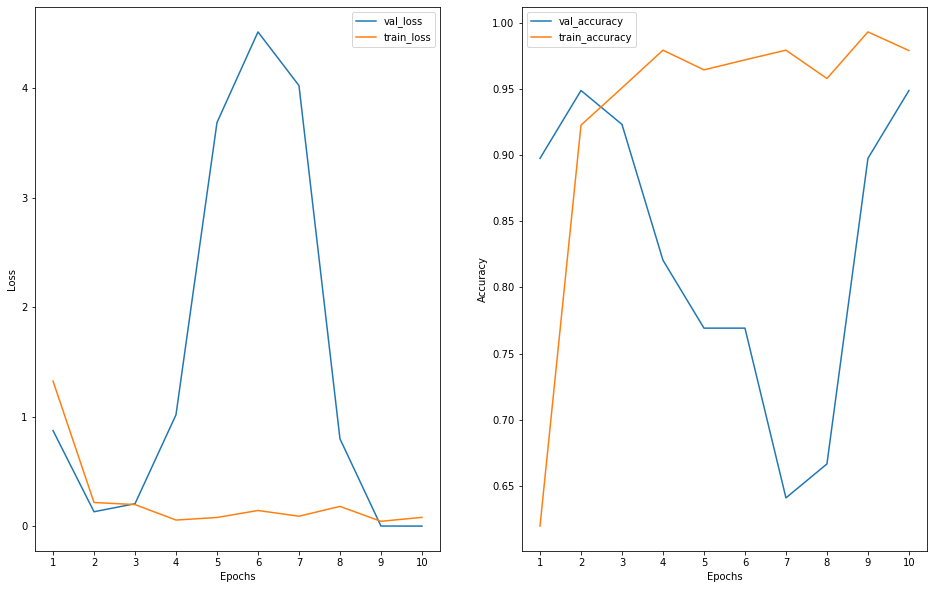

In [7]:
epochs = 10
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
ax1.plot(np.arange(1, epochs + 1), model.history.history['val_loss'], label = 'val_loss')
ax1.plot(np.arange(1, epochs + 1), model.history.history['loss'], label = 'train_loss')
ax1.set_xticks(np.arange(1, epochs + 1))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(np.arange(1, epochs + 1), model.history.history['val_accuracy'], label = 'val_accuracy')
ax2.plot(np.arange(1, epochs + 1), model.history.history['accuracy'], label = 'train_accuracy')
ax2.set_xticks(np.arange(1, epochs + 1))
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

### Predicting on test data set

In [20]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

In [21]:
predict[::2]

array([[9.9971920e-01, 3.3424400e-05, 2.4738355e-04],
       [9.9997675e-01, 6.8709295e-07, 2.2562443e-05],
       [1.6187531e-01, 9.9206762e-04, 8.3713263e-01],
       [2.5638830e-04, 1.1220233e-04, 9.9963140e-01],
       [8.7973248e-04, 4.3597040e-05, 9.9907660e-01],
       [1.0912658e-03, 9.9876910e-01, 1.3966870e-04],
       [5.3023285e-01, 2.2998902e-03, 4.6746719e-01],
       [9.9737251e-01, 2.0191206e-03, 6.0838775e-04],
       [6.4211022e-08, 4.6964328e-07, 9.9999952e-01],
       [2.8510433e-01, 7.3206535e-04, 7.1416354e-01],
       [2.5320038e-10, 7.3408357e-10, 1.0000000e+00],
       [5.9178589e-08, 7.2161797e-08, 9.9999988e-01],
       [1.9740312e-09, 1.9588597e-09, 1.0000000e+00]], dtype=float32)

In [22]:
y_true_labels = test_generator.classes
y_true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2])

In [23]:
y_pred_labels = np.argmax(predict, axis = 1)
y_pred_labels

array([0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2,
       2, 2, 2], dtype=int64)

### Confusion matrix

In [24]:
confusion_matrix(y_true_labels, y_pred_labels)

array([[6, 0, 3],
       [3, 3, 5],
       [0, 0, 5]], dtype=int64)